In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import math

In [2]:
def remove_other(s):
    n = re.sub('\D', '', str(s))
    if n != '':
        return int(n)
    return -1

def year_to_int(df):
    df_years = df['Year'].apply(remove_other)
    return df_years

def get_senior_years(df):
    l = []
    for id_ in df['player_id'].drop_duplicates():
        l.append(df[df['player_id'] == id_].iloc[-1])
    return l

def check_digit(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
nfl = pd.read_csv(os.path.join('data', 'nfl_data.csv'))
cfl = pd.read_csv(os.path.join('data', 'cfl_data.csv'))
player_ids = pd.read_csv(os.path.join('data', 'player_ids.csv'))
nfl_num = nfl[nfl['GS'].apply(check_digit)]
nfl_played = nfl_num[pd.to_numeric(nfl_num['GS']) > 0]

In [4]:
def transform_records(df):
    # Sum career record, give score equal to total wins - (losses / 10)
    filled = df.copy()
    filled['QBrec'] = filled['QBrec'].fillna(value="0-5-0")
    qb_scores = pd.DataFrame()
    scores = []
    ids = df['player_id'].drop_duplicates()
    for id_ in ids:
        sum_ = 0
        # Get value of QBrec for each year
        recs = filled['QBrec']
        for rec in recs[df['player_id'] == id_]:
            # Clean this up with another function
            nums = re.search("(\d+)-(\d+)", rec)
            if nums is not None:
                sum_ += float(nums.group(1)) + float(nums.group(2)) / 16
        scores.append(sum_ ** (1/3))
        
    qb_scores['score'] = scores 
    qb_scores['player_id'] = ids.reset_index(drop=True)
    
    return qb_scores

In [5]:
nfl_records = nfl_played[['QBrec', 'player_id']]
nfl_scores = transform_records(nfl_records)

In [6]:
full_data = cfl.merge(nfl_scores, how='inner', on='player_id')
full_data['Year'] = year_to_int(full_data)

In [7]:
# Drops career stats
rec_data = full_data[full_data['Year'] > 1990]

In [8]:
rec_senior = pd.DataFrame(get_senior_years(rec_data))
rec_final = rec_senior[rec_senior['Pos'] == 'QB']
rec_final_qbs = rec_final.drop(['Unnamed: 0', 'Class', 'Year', 'School', 'Pos', 'player_id'], axis=1)
rec_final_qbs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 12 to 2678
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Conf    297 non-null    object 
 1   G       297 non-null    float64
 2   Cmp     297 non-null    float64
 3   Att     297 non-null    float64
 4   Pct     297 non-null    float64
 5   Yds     297 non-null    float64
 6   Y/A     297 non-null    float64
 7   AY/A    297 non-null    float64
 8   TD      297 non-null    float64
 9   Int     297 non-null    float64
 10  Rate    297 non-null    float64
 11  score   297 non-null    float64
dtypes: float64(11), object(1)
memory usage: 30.2+ KB


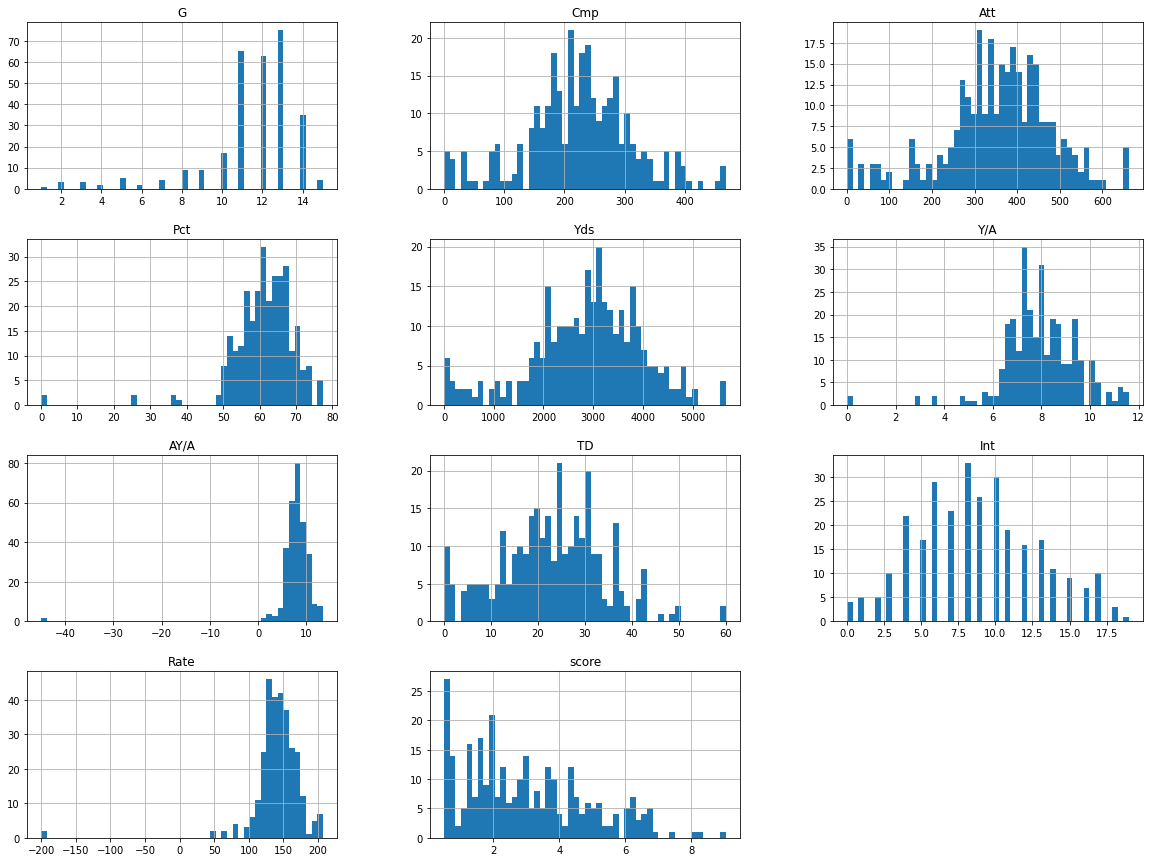

In [9]:
rec_final_qbs.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
rec_final_qbs['play_time'] = pd.cut(rec_final_qbs['G'], bins=6, labels=[1, 2, 3, 4, 5, 6])

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

rec_final_qbs = rec_final_qbs.reset_index(drop=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
for train_index, test_index in split.split(rec_final_qbs, rec_final_qbs["play_time"]):
    train_set = rec_final_qbs.loc[train_index]
    test_set = rec_final_qbs.loc[test_index]
    
train_set["play_time"].value_counts() / len(train_set)

5    0.430052
6    0.383420
4    0.088083
3    0.051813
2    0.025907
1    0.020725
Name: play_time, dtype: float64

In [12]:
for set_ in (train_set, test_set):
    set_.drop("play_time" "", axis=1, inplace=True)

In [13]:
qb_stats = train_set.copy()
corr_matrix = qb_stats.corr()
corr_matrix['score'].sort_values(ascending=False)

score    1.000000
AY/A     0.079321
Rate     0.058994
G        0.056419
TD       0.054671
Pct      0.030632
Yds      0.026691
Cmp      0.023792
Y/A      0.018386
Att      0.005063
Int     -0.008661
Name: score, dtype: float64

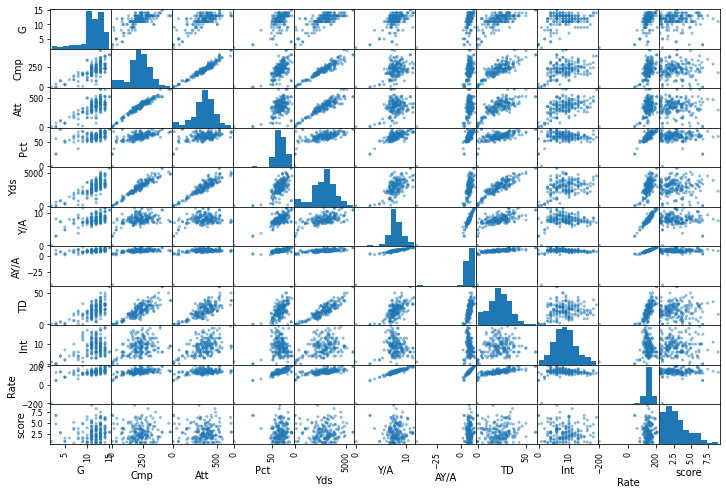

In [14]:
from pandas.plotting import scatter_matrix

scatter_matrix(qb_stats, figsize=(12,8))
plt.show()

In [15]:
qb_stats['TD/G'] = qb_stats['TD']/qb_stats['G']
qb_stats['Int/G'] = qb_stats['Int']/qb_stats['G']
qb_stats['GAR'] = qb_stats['Rate'] * qb_stats['G'].apply(lambda x : x ** 2)
qb_stats['C/G'] = qb_stats['Cmp'] / qb_stats['G']
qb_stats['Y/G'] = qb_stats['Yds'] / qb_stats['G']

In [16]:
corr_matrix = qb_stats.corr()
corr_matrix['score'].sort_values(ascending=False)

score    1.000000
GAR      0.097819
AY/A     0.079321
Rate     0.058994
G        0.056419
TD       0.054671
Pct      0.030632
Yds      0.026691
Cmp      0.023792
Y/A      0.018386
TD/G     0.009201
Att      0.005063
Int     -0.008661
Y/G     -0.034518
C/G     -0.037514
Int/G   -0.075193
Name: score, dtype: float64

In [17]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
qb_stats_cat = qb_stats[['Conf']]
qb_stats_cat_1hot = cat_encoder.fit_transform(qb_stats_cat)
qb_stats_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

g_ix, int_ix, rate_ix = 0, 8, 9

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        game_adjusted_rating = X[:, rate_ix] * (X[:, g_ix] ** 2)
        int_per_game = np.divide(X[:, int_ix], X[:, g_ix], out=np.zeros_like(X[:, int_ix]), where=X[:, g_ix]!=0)
        return np.c_[X, game_adjusted_rating, int_per_game]
        
qb_stats = train_set.drop("score", axis=1)
qb_labels = train_set["score"].copy()

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [20]:
from sklearn.compose import ColumnTransformer

num_attribs = list(qb_stats.drop(['Conf'], axis=1))
cat_attribs = ["Conf"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

qb_prepped = full_pipeline.fit_transform(qb_stats)

In [21]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [22]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(qb_prepped, qb_labels)

forest_scores = cross_val_score(forest_reg, qb_prepped, qb_labels,
                            scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [1.7149895  2.45774294 2.1037842  1.50290984 2.06375623 1.58695602
 2.04702477 1.20987635 1.22251188 2.07259139]
Mean: 1.7982143106210748
Standard deviation: 0.3940036701596283


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(qb_prepped, qb_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.9729608507547247 {'max_features': 2, 'n_estimators': 3}
1.9212349981978907 {'max_features': 2, 'n_estimators': 10}
1.8262343398072336 {'max_features': 2, 'n_estimators': 30}
2.1101669177957874 {'max_features': 4, 'n_estimators': 3}
1.8860160117753666 {'max_features': 4, 'n_estimators': 10}
1.8429468457951859 {'max_features': 4, 'n_estimators': 30}
2.187051792413082 {'max_features': 6, 'n_estimators': 3}
1.902290041761705 {'max_features': 6, 'n_estimators': 10}
1.8744613191821329 {'max_features': 6, 'n_estimators': 30}
2.014970232747932 {'max_features': 8, 'n_estimators': 3}
1.8962892169205485 {'max_features': 8, 'n_estimators': 10}
1.8467459136070952 {'max_features': 8, 'n_estimators': 30}
2.036552674829306 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
1.8491636691295523 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
2.0551747179238546 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
1.875138331092167 {'bootstrap': False, 'max_features': 3, 'n_esti

In [25]:
param_grid = [
    {'n_estimators': [30, 100, 300], 'max_features': [2, 4, 6]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(qb_prepped, qb_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [30, 100, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.811379850199357 {'max_features': 2, 'n_estimators': 30}
1.8083821875321473 {'max_features': 2, 'n_estimators': 100}
1.78319911525931 {'max_features': 2, 'n_estimators': 300}
1.8398831624490786 {'max_features': 4, 'n_estimators': 30}
1.8222353985874415 {'max_features': 4, 'n_estimators': 100}
1.8141657620796696 {'max_features': 4, 'n_estimators': 300}
1.8662290305077756 {'max_features': 6, 'n_estimators': 30}
1.8328364741594247 {'max_features': 6, 'n_estimators': 100}
1.821415547665948 {'max_features': 6, 'n_estimators': 300}


In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(qb_prepped, qb_labels)

LinearRegression()

In [28]:
from sklearn.metrics import mean_squared_error
qb_predictions = lin_reg.predict(qb_prepped)
lin_mse = mean_squared_error(qb_predictions, qb_labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.6289893196723675

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(qb_prepped, qb_labels)

DecisionTreeRegressor()

In [30]:
scores = cross_val_score(tree_reg, qb_prepped, qb_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [31]:
display_scores(tree_rmse_scores)

Scores: [2.27580097 2.90992256 2.99587849 2.17069827 3.03527093 2.24298773
 3.04061043 1.556194   2.39998549 2.48967816]
Mean: 2.511702703050333
Standard deviation: 0.46010611967666093


In [32]:
final_model = lin_reg

X_test = test_set.drop("score", axis=1)
y_test = test_set["score"]

X_test_prepared = full_pipeline.transform(X_test)
test_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, test_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2.0144733615706056

In [33]:
test_set["pred"] = test_predictions

In [34]:
test_set.sort_values("pred", ascending=False)

,Conf,G,Cmp,Att,Pct,Yds,Y/A,AY/A,TD,Int,Rate,score,pred
280,MVC,1.0,15.0,30.0,50.0,149.0,5.0,4.8,2.0,1.0,107.1,1.285641,6.387885
135,Pac-10,2.0,5.0,13.0,38.5,87.0,6.7,6.7,0.0,0.0,94.7,2.957741,6.331874
150,ACC,15.0,388.0,579.0,67.0,4593.0,7.9,8.0,41.0,17.0,151.1,3.895744,4.497724
269,MAC,14.0,342.0,495.0,69.1,4486.0,9.1,9.6,37.0,10.0,165.8,6.980387,4.388566
278,MAC,13.0,278.0,465.0,59.8,3540.0,7.6,7.1,23.0,16.0,133.2,1.259921,4.207219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,SWC,10.0,278.0,497.0,55.9,3388.0,6.8,6.4,29.0,17.0,125.6,2.506649,2.035080
170,Big East,8.0,145.0,239.0,60.7,1729.0,7.2,5.7,11.0,13.0,125.7,4.460561,1.786685
256,American,13.0,259.0,382.0,67.8,3581.0,9.4,9.6,25.0,9.0,163.4,4.330085,1.697429
237,American,13.0,296.0,443.0,66.8,3776.0,8.5,9.4,28.0,4.0,157.5,1.334201,1.345014


In [35]:
test_set['score'].corr(test_set['pred'])

0.08967780486496557

In [37]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


In [40]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [41]:
model = build_and_compile_model()

2022-07-16 20:32:41.448072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
history = model.fit(
    qb_prepped,
    qb_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [47]:
results = model.evaluate(X_test_prepared, y_test, verbose=0)

In [50]:
test_set['pred'] = model.predict(X_test_prepared)

4/4 [==============================] - 0s 1ms/step


In [53]:
test_set.sort_values("pred", ascending=False)

,Conf,G,Cmp,Att,Pct,Yds,Y/A,AY/A,TD,Int,Rate,score,pred
194,ACC,13.0,330.0,564.0,58.5,4031.0,7.1,6.9,31.0,17.0,130.7,2.830928,5.598586
198,Pac-10,12.0,279.0,515.0,54.2,3615.0,7.0,6.7,29.0,17.0,125.1,4.029726,5.572129
280,MVC,1.0,15.0,30.0,50.0,149.0,5.0,4.8,2.0,1.0,107.1,1.285641,5.378999
278,MAC,13.0,278.0,465.0,59.8,3540.0,7.6,7.1,23.0,16.0,133.2,1.259921,5.145379
139,Pac-12,15.0,304.0,445.0,68.3,4454.0,10.0,11.5,42.0,4.0,181.7,4.530655,4.970723
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,SEC,12.0,192.0,296.0,64.9,3082.0,10.4,10.7,22.0,8.0,171.4,1.077217,1.016304
148,Big Ten,2.0,0.0,1.0,0.0,0.0,0.0,-45.0,0.0,1.0,-200.0,0.825482,0.961426
199,Pac-12,11.0,222.0,358.0,62.0,2714.0,7.6,8.8,28.0,3.0,149.8,0.721125,0.927194
207,MWC,12.0,289.0,417.0,69.3,3885.0,9.3,10.0,32.0,8.0,169.1,1.094880,0.849828
